In [1]:
# Importing the necessary libraries
import tensorflow as tf
import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\LAKSHMI SRI
[nltk_data]     LASYA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\LAKSHMI SRI
[nltk_data]     LASYA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\LAKSHMI SRI
[nltk_data]     LASYA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
dataList = []
sentences = []
labels = []
def loadDataset(filename):
  d=[]
  with open(filename, 'r') as f:
      datastore = json.load(f)
  for item in datastore:
    sentence = item['data']
    label = item['is_sensitive']
    d.append([sentence,label])
  return d
# Loading both sensitive and non-sensitive dataset
sen=loadDataset("SensitiveDataset.json")
nonsen=loadDataset("NonSensitiveDatasetnew.json")

In [3]:
sen=pd.DataFrame(data=sen,columns=['sentences','labels'])
nonsen=pd.DataFrame(data=nonsen,columns=['sentences','labels'])

In [4]:
tokenized_data = [word_tokenize(sentence) for sentence in nonsen['sentences']]
stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
stop_words.update(punctuations)
stemmer = PorterStemmer()
filtered_data = [[stemmer.stem(word) for word in sentence if word.lower() not in stop_words] for sentence in tokenized_data]
l=[]
for idx, sentence in enumerate(filtered_data):
    l.append(' '.join(sentence))
nonsen['sentences']=l
sen['labels']=1
nonsen['labels']=0

In [5]:
combined = pd.concat([sen, nonsen])
df = combined.sample(frac=1).reset_index(drop=True)
df.head()

,sentences,labels
0,"misti, palomita, misti@yahoo.co.id, 225...",1
1,"card no:7116 2755 5365 8246, expiry month:aug-...",1
2,high school senior walter gibson best friend l...,0
3,"ssn:796-08-3737, name:john",1
4,movi begin world war young man name jimmi fran...,0


(array([16000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 15576.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

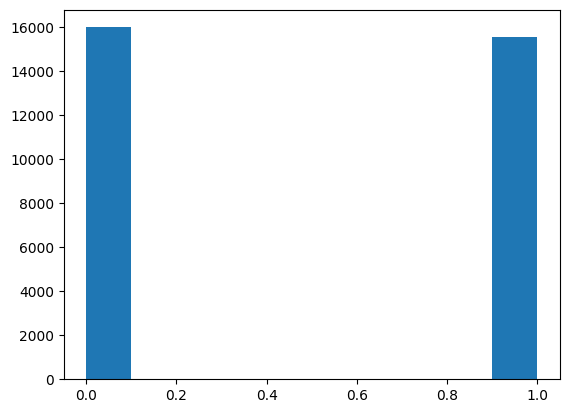

In [6]:
plt.hist(df['labels'])

In [7]:
X = df['sentences']
y = df['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(25260,) (6316,) (25260,) (6316,)


In [8]:
#get unique words in X
words = []
for i in range(len(X)):
  for word in X[i].split():
    words.append(word)
words = list(set(words))
vocab_size = len(words)
print("Number of unique words in the dataset: ", len(words))

Number of unique words in the dataset:  127701


In [9]:
#how to set maxlen
max_length = 0
for i in range(len(X)):
  if len(X[i].split()) > max_length:
    max_length = len(X[i].split())
print("Max length of the sentence: ", max_length)

Max length of the sentence:  2683


In [10]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
# convert the sentences into sequences of integers
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
# pad the sequences so they are all the same length
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)
print(train_padded.shape, test_padded.shape)

(25260, 2683) (6316, 2683)


In [11]:
train_padded = np.array(train_padded)
test_padded = np.array(test_padded)
y_train = np.array(y_train)
y_test = np.array(y_test)  

In [12]:
# Assuming labels is your numpy array of labels
unique_classes = np.unique(y_train)
class_num = unique_classes.size
print("Number of unique classes: ", class_num)

Number of unique classes:  2


In [13]:
# LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 32, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(class_num, activation='softmax')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2683, 32)          4086432   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 4105218 (15.66 MB)
Trainable params: 4105218 (15.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
num_epochs = 5
history = model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(test_padded, y_test), verbose=2)

Epoch 1/5


ValueError: in user code:

    File "c:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "c:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\LAKSHMI SRI LASYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)).


In [ ]:
from tensorflow.keras import Model, regularizers, constraints
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay

class TextRNN(Model):
    def __init__(self, 
                 maxlen, 
                 max_features, 
                 embedding_dims,
                 class_num=2,
                 last_activation='sigmoid',
                 l2_reg_lambda=0.0):  # Add regularization parameter
        super(TextRNN, self).__init__()
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation
        self.embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)
        self.rnn1 = LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(l2_reg_lambda), kernel_constraint=constraints.MaxNorm(2))  # Add regularization and weight constraint
        self.rnn2 = LSTM(128, kernel_regularizer=regularizers.l2(l2_reg_lambda), kernel_constraint=constraints.MaxNorm(2))  # Add regularization and weight constraint
        self.dropout = Dropout(0.2)
        self.classifier = Dense(self.class_num, activation=self.last_activation, kernel_regularizer=regularizers.l2(l2_reg_lambda), kernel_constraint=constraints.MaxNorm(3))  # Add regularization and weight constraint

        lr_schedule = ExponentialDecay(
            initial_learning_rate=1e-2,
            decay_steps=10000,
            decay_rate=0.9)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    def call(self, inputs):
        if len(inputs.shape) != 2:
            raise ValueError('The rank of inputs of TextRNN must be 2, but now is %d' % len(inputs.get_shape()))
        if inputs.shape[1] != self.maxlen:
            raise ValueError('The maxlen of inputs of TextRNN must be %d, but now is %d' % (self.maxlen, inputs.get_shape()[1]))
        embedding = self.embedding(inputs)
        x = self.rnn1(embedding)
        x = self.rnn2(x)
        x = self.dropout(x)
        output = self.classifier(x)
        return output

In [ ]:
#find embedding dimension
max_features = len(tokenizer.word_index) + 1
embedding_dims = 32
model = TextRNN(maxlen=max_length,
                max_features=max_features,
                embedding_dims=embedding_dims)

print('Build model...')
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

#Use call function from TextRNN class and give inputs as training_padded
model.call(train_padded)

# Display the summary of the model
#model.summary()

num_epochs = 5

# model.fit - Train the model for a fixed number of epochs
history = model.fit(train_padded, 
                    y_train, 
                    epochs=num_epochs, 
                    validation_data=(test_padded, y_test), 
                    verbose=2)     
              # callbacks=[callbacks])

Build model...


KeyboardInterrupt: 

In [ ]:
# Sample examples
sentence = ['username:lasya','email:lasya@gmail.com','food is delicious','phone no:7865432156','1234 4567 8976','This is a fantabulous book']
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
predictions = model.predict(padded)
#sort predictions in ascending order
predictions.sort()
for i in range(len(predictions)):
  print(sentence[i],predictions[i][0])

t=(min(y_predicted)+max(y_predicted))/2

y_labels = predictions > t
#print(y_predicted_labels)
size = np.size(y_labels)
y_labels = y_labels.reshape(size, )

"""
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
# Implement K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(predictions)
# Create a mapping from labels to names
label_names = {0: "Non-Sensitive", 1: "Sensitive"}
# Print the cluster each sentence belongs to
for i in range(len(sentence)):
  print(f"Sentence: {sentence[i]}")
  print(f"Cluster: {label_names[kmeans.labels_[i]]}")
"""

1/1 [==============================] - 0s 26ms/step
username:lasya 0.9997238
email:lasya@gmail.com 0.9996277
food is delicious 0.9968918
phone no:7865432156 0.9996614
1234 4567 8976 0.99772763
This is a fantabulous book 0.9773593


'\nfrom sklearn.cluster import KMeans\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n# Implement K-Means clustering\nkmeans = KMeans(n_clusters=2, random_state=0).fit(predictions)\n# Create a mapping from labels to names\nlabel_names = {0: "Non-Sensitive", 1: "Sensitive"}\n# Print the cluster each sentence belongs to\nfor i in range(len(sentence)):\n  print(f"Sentence: {sentence[i]}")\n  print(f"Cluster: {label_names[kmeans.labels_[i]]}")\n'

In [ ]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

import seaborn
import pandas as pd
print('Confusion Matrix')
y_predicted = model.predict(validation_padded)

print("Threshold",(min(y_predicted)+max(y_predicted))/2)
t=(min(y_predicted)+max(y_predicted))/2

y_predicted_labels = y_predicted > t
#print(y_predicted_labels)
size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )

cm = tf.math.confusion_matrix(validation_labels,y_predicted_labels)
cm_np = cm.numpy()
conf_acc = ((cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np)) * 100
print("Accuracy for Test Data = ", conf_acc)
plt.figure(figsize = (10,7))
seaborn.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix for Test Data")
plt.xlabel('Predicted')
plt.ylabel('Expected')

from sklearn.metrics import classification_report,accuracy_score
report = classification_report(validation_labels,y_predicted_labels)
#print("Classification Report:\n", report)
print("Accuracy Score:", accuracy_score(validation_labels,y_predicted_labels)*100)


In [ ]:
# Sample examples
sentence = ['Sr No', ' Blood Bank Name', ' State', ' District', ' City', ' Address',             
       'Pincode', ' Contact No', 'phone', ' Helpline', ' Fax', ' Email',                 
       ' Website', ' Nodal Officer ', ' Contact Nodal Officer',                   
       ' Mobile Nodal Officer', ' Email Nodal Officer',                              
       ' Qualification Nodal Officer', ' Category',                                       
       ' Blood Component Available', ' Apheresis', ' Service Time',                             
       ' License #', ' Date License Obtained', ' Date of Renewal', ' Latitude',                   
       ' Longitude','card no','expiry date']
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
predictions = model.predict(padded)
for i in range(len(predictions)):
  print(predictions[i][0])
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
# Implement K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(predictions)
# Create a mapping from labels to names
label_names = {0: "Non-Sensitive", 1: "Sensitive"}
# Print the cluster each sentence belongs to
for i in range(len(sentence)):
  print(f"Sentence: {sentence[i]}")
  print(f"Cluster: {label_names[kmeans.labels_[i]]}")
# Training accuracy
train_loss, train_acc = model.evaluate(training_padded, training_labels, verbose=0)
print('Training Accuracy: %f' % (train_acc*100))

# Testing accuracy
test_loss, test_acc = model.evaluate(validation_padded, validation_labels, verbose=0)
print('Testing Accuracy: %f' % (test_acc*100))
